In [1]:
import cv2 as cv
import os
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
# filename='christiner3.bmp'

In [21]:
def get_random_file(root_folder, exclude_folder=[]):
    # Get a list of all files (recursively) in the folder
    all_files = []
    for foldername, subfolders, filenames in os.walk(root_folder):
        # Exclude the specified folder
        if exclude_folder in subfolders:
            subfolders.remove(exclude_folder)

        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            all_files.append(file_path)

    # Check if there are any files in the folder
    if not all_files:
        print("No files found in the specified folder.")
        return None

    # Choose a random file
    random_file = random.choice(all_files)

    return random_file


In [22]:
folder_path = os.path.join('Images','Iris System')
exclude_folder_name = ['Normalized_Images']

random_file_path = get_random_file(folder_path, exclude_folder_name)

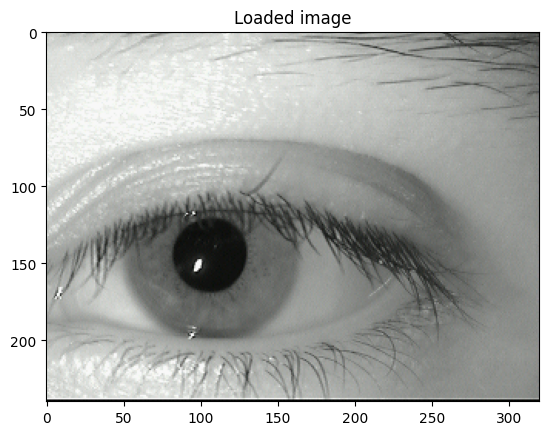

In [23]:
main_image = cv.imread(random_file_path)
if main_image is None:
    print ('Error opening image!')
    print ('Usage: hough_circle.py [image_name -- default ' + filename + '] \n')

#opencv stores image in BGR format and matplot lib expects it in RGB
plt.title("Loaded image")
plt.imshow(cv.cvtColor(main_image,cv.COLOR_BGR2RGB))

rows=240,cols=320


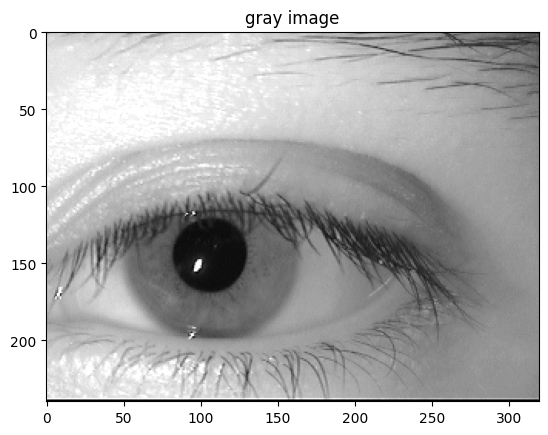

In [24]:
# Convert it to gray
gray_image = cv.cvtColor(main_image, cv.COLOR_BGR2GRAY)
rows,cols= gray_image.shape
print(f"rows={rows},cols={cols}")
plt.title("gray image")
plt.imshow(gray_image,cmap='grey')

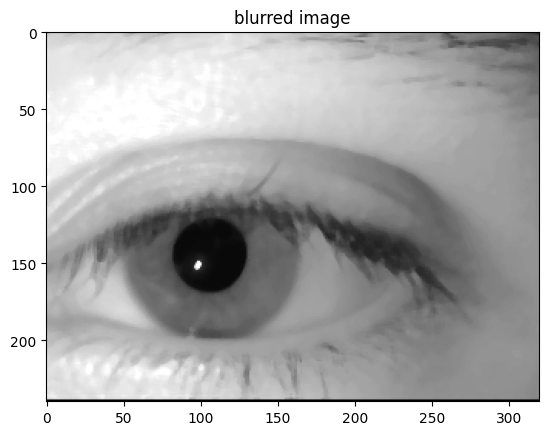

In [25]:
# Reduce the noise to avoid false circle detection
median_blurred_image = cv.medianBlur(gray_image, 5)
plt.title("blurred image")
plt.imshow(median_blurred_image,cmap='grey')

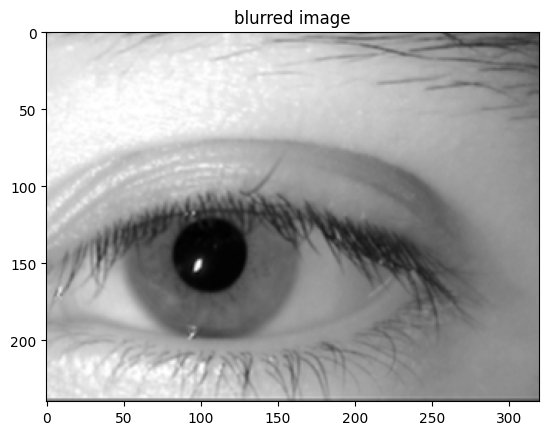

In [26]:
# Reduce the noise to avoid false circle detection
#  if sigmaY is zero, it is set to be equal to sigmaX, if both sigmas are zeros, they are computed from 
# ksize.width and ksize.height, respectively (see getGaussianKernel for details); to fully control the 
# result regardless of possible future modifications of all this semantics, it is recommended to specify all of ksize, 
# sigmaX, and sigmaY.
gaussian_blurred_image = cv.GaussianBlur(gray_image,ksize=(3,3),sigmaX=0,sigmaY=0)
plt.title("blurred image")
plt.imshow(gaussian_blurred_image,cmap='grey')

In [27]:
chosen_image=median_blurred_image

In [32]:
#use hough transform to calulate circles of certain radius
circles = cv.HoughCircles(chosen_image, cv.HOUGH_GRADIENT, dp=1, minDist=rows/8,
                           param1=100, param2=30,
                           minRadius=20, maxRadius=50)
if(type(circles) == None):
    raise Exception("No circles detected. Error")

In [33]:
if(len(circles)>1):
    raise Exception("Multiple circles detected. Error")

if(len(circles)<1):
    raise Exception("No circles detected. Error")

circles = np.uint16(np.around(circles))

pupil_center = (circles[0,0,0], circles[0,0,1])
# circle center
cv.circle(main_image, pupil_center, 1, (255, 0, 255), 3)
# circle outline
pupil_radius = circles[0,0,2]
cv.circle(main_image, pupil_center, pupil_radius, (255, 0, 255), 3)

print(f"pupil_center={pupil_center},pupil_radius={pupil_radius}")

pupil_center=(106, 144),pupil_radius=24


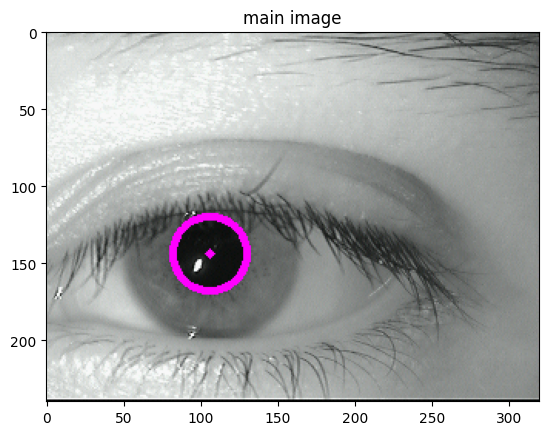

In [34]:
plt.title("main image")
plt.imshow(main_image)

## Trying to find point of maxium intensity change along center row (Failed)

In [35]:
arr=np.array(chosen_image).reshape(rows,cols).astype(int)
arr[pupil_center[0]]

array([202, 198, 197, 194, 197, 199, 199, 202, 206, 208, 215, 218, 223,
       223, 224, 223, 205, 198, 194, 192, 191, 192, 193, 194, 195, 198,
       203, 208, 209, 209, 213, 213, 210, 209, 199, 194, 189, 184, 182,
       181, 182, 182, 181, 183, 183, 183, 183, 183, 184, 186, 186, 186,
       186, 186, 184, 184, 184, 184, 184, 186, 184, 181, 181, 178, 177,
       176, 176, 176, 176, 170, 170, 170, 170, 170, 171, 173, 173, 173,
       176, 176, 176, 183, 185, 186, 184, 184, 181, 178, 178, 178, 178,
       178, 175, 168, 165, 165, 162, 159, 157, 157, 152, 154, 151, 144,
       139, 122, 122, 122, 125, 138, 144, 152, 153, 157, 154, 142, 136,
       133, 130, 117, 117, 134, 136, 136, 135, 134, 127, 127, 127, 127,
       119, 114, 114, 117, 128, 130, 130, 130, 130, 128, 135, 138, 141,
       142, 142, 138, 136, 134, 134, 133, 130, 128, 128, 128, 130, 134,
       136, 138, 144, 146, 146, 146, 146, 144, 144, 144, 144, 144, 144,
       146, 146, 146, 146, 147, 149, 150, 149, 146, 146, 146, 14

In [36]:
dI=np.zeros((cols))
for i in range(cols):
    try:
        # -1 is interpreted as last element
        if(i==0 or i ==1):
            raise Exception()
        dI[i]=abs(arr[pupil_center[0],i+2]+arr[pupil_center[0],i+1]-arr[pupil_center[0],i-1]-arr[pupil_center[0],i-2])
    except:
        #ahile lai 0
        dI[i]=0

In [37]:
#see in image it occurs near eyelids
np.argmax(dI)

16

In [38]:
radius2=abs(pupil_center[0]-np.argmax(dI))
no_region_main=main_image.copy()
cv.circle(no_region_main, pupil_center, int(radius2), (255, 0, 255), 3)
radius2

90

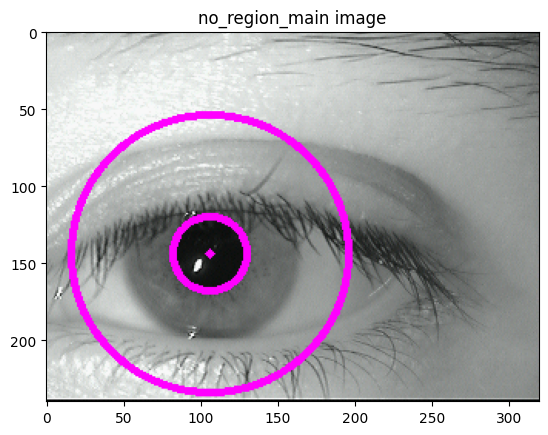

In [39]:
plt.title("no_region_main image")
plt.imshow(no_region_main)

# Implementation of a search radius

In [40]:
r=pupil_radius
min_r=int(1.8*r)
max_r=int(2.4*r)
xc,yc=pupil_center

In [41]:
dI=np.zeros((max_r-min_r))

In [42]:
for i in range(xc+min_r,xc+max_r):
    dI[i-(xc+min_r)]=abs(arr[pupil_center[0],i+2]+arr[pupil_center[0],i+1]-arr[pupil_center[0],i-1]-arr[pupil_center[0],i-2])

In [43]:
np.argmax(dI)

8

In [44]:
radius3=min_r+np.argmax(dI)
one_region_main=main_image.copy()
cv.circle(one_region_main, pupil_center, int(radius3), (255, 0, 255), 3)
radius3

51

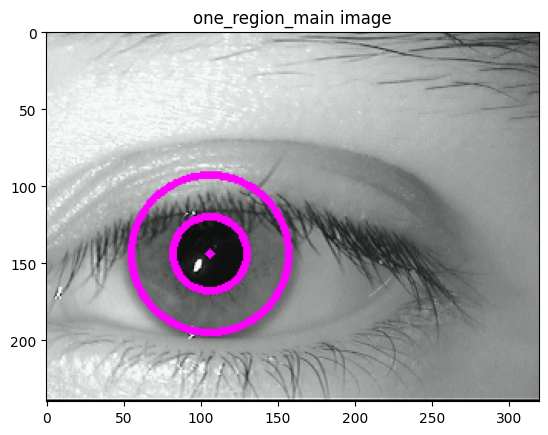

In [45]:
plt.title("one_region_main image")
plt.imshow(one_region_main)

## Two search region on left and right and taking closest to average value for humans


In [46]:
r=pupil_radius
min_r=int(1.8*r)
max_r=int(2.4*r)
xc,yc=pupil_center

In [47]:
dI_right=np.zeros((max_r-min_r))

In [48]:
for i in range(xc+min_r,xc+max_r):
    dI_right[i-(xc+min_r)]=abs(arr[pupil_center[0],i+2]+arr[pupil_center[0],i+1]-arr[pupil_center[0],i-1]-arr[pupil_center[0],i-2])

In [49]:
dI_left=np.zeros((max_r-min_r))

In [54]:
for i in range(xc-max_r,xc-min_r):
    dI_left[i-(xc-max_r)]=abs(arr[pupil_center[0],i+2]+arr[pupil_center[0],i+1]-arr[pupil_center[0],i-1]-arr[pupil_center[0],i-2])

In [55]:
r1=min_r+np.argmax(dI_right)
r2=min_r+np.argmax(dI_left)
r1,r2,r

(51, 55, 24)